# Berlin Terraces - Decision Tree

**Author:** Lonny Chen<br>
**Contact:** lonny.cl.chen@gmail.com<br>
**Repository:** https://github.com/lonnychen/Berlin-Terraces<br>
**Last Updated:** 1 June, 2021

This data mini-project attempts to answer the predictive question of:

> ### *How do I find the sun terraces in Berlin?*

Inspirational tagline:

> ### *Meet me on my ter{1,2}a(c|s){1,2}e?*

**Motivation:**<br>
1. Demonstrate beginning data science and Python coding skills as my "evidence of technical training" upload for my application to the Hertie School's Master of Data Science for Public Policy program. My learning path was largely informed by chapters three and four of "Data Science: Concepts and Practice" by Vijay Kotu and Bala Deshpande ([amazon](https://www.amazon.ca/Predictive-Analytics-Data-Mining-Concepts/dp/012814761X), [official](http://www.introdatascience.com/)), materials found in Huy Ngoc Dang's [repository](https://github.com/huydang90/Hertie-School-Data-Science-Society) for the Hertie School Data Science Society, and the data science core skils learning path on [Real Python](https://realpython.com/learning-paths/data-science-python-core-skills/). Also, a very honorable mention to [Jason Brownlee PhD](https://machinelearningmastery.com/) for his articles and reference code provided to explain important machine learning concepts.
2. Learn a bit about neighborhoods (or at least districts in this iteration) in [Berlin](https://www.visitberlin.de/en/neighbourhoods-berlin) and have some fun browsing nice photos of terraces on Airbnb.com. This was inspired after hearing about the attractive idea of renting apartments with "sun terraces" in Berlin during a Hertie School information session which seemed possible but not entirely common. Perhaps this could be a simple, not too profound, exercise for learning more about predictive algorithms using a real-world dataset?

**Summary of Findings**:<br>
From data exploration, the best potential features for predicting terraces:
> - Higher prices
> - More consistent high ratings
> - District: best best is Pankow, worse bet is Neukölln
> - Room type: best best is Entire room/apt, much better than Private room<br>

Interesting observation:
- There is a negative correlation between price and the **range** of ratings, or in plain English:
> *Pricier listings have more exclusively high ratings, and lower prices have more mixed quality.*

From decision tree building, evaluation, and optimization, the most important features for predicting terraces are showing to be (needs deeper analysis):
> 1. Rating
> 2. Price
> 3. Is the listing in Friedrichshain-Kreuzberg?
> 4. Is the listing in Pankow?
> 5. Is the listing in Charlottenburg-Wilmersdorf?

**Dataset:**<br>
The [Inside Airbnb](http://insideairbnb.com/about.html) project, created by Murray Cox, provides publicly available datasets of Airbnb rental listings in different cities around the world including Berlin. At a high-level:
- Advantage: a real-world, regularly updated, dataset (>15k listings) that is location-specific to Berlin,
- Disadvantage: not an exact picture of the longer-term rental housing market in Berlin<br>

Others have executed data projects using Airbnb Berlin data and I have used their work as references frequently:
1. Jesper Dramsch on [Kaggle](https://www.kaggle.com/jesperdramsch/berlin-airbnbs-is-it-really-all-about-location?scriptVersionId=39421424)
2. Katherine Edgley on [towards data science](https://towardsdatascience.com/a-visual-data-driven-look-at-airbnb-hosting-in-berlin-729eccd8bf9d)

**Technique - Decision Trees:** <br>
- Idea: *Recursive partitioning*<br>
- Math: [Shannon Entropy (h)](https://www.youtube.com/watch?v=9r7FIXEAGvs), [Information Gain (IG)](https://www.youtube.com/watch?v=IPkRVpXtbdY)<br>
- Tuning parametres: decision criterion (Gini, Entropy), pre/post-pruning STOP [conditions](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)<br>
- Advantages: white box (explanatory), robust versus missing, outlier, un-scaled data<br>
- Disadvantage: **overfits** data if tree model not pruned<br>

**Process Steps:**<br>
1. **Prepare data:** data cleaning, feature engineering
2. **Data exploration:** uni/multivariate exploration on numerical, categorical features
3. **Pre-process data:** split, encode
4. **Build model:** fit, plot tree, feature importance
5. **Evaluate model:** confusion matrix
6. **Optimize model:** tuning parameters, cross-validation<br>

**Possible Next Steps:**<br>
- [Nested cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html), seemingly the state-of-the-art method to really test out an optimized model
- Map the Berlin districts with terrace True vs False information to explore the geo-spatial differences between districts
- try "neighourhood" as a feature or would 138 different features crash the tool?
- engineer these features as inputs into the decision tree algorithm:
    - "distance from centre" using latitude and latitude variables
    - "property" from current property type variable

## Import packages, functions, and classes
**Python Libraries:**
- NumPy, Pandas
- Matplotlib
- Scikit-learn [decision trees](https://scikit-learn.org/stable/modules/tree.html)<br>
- Math, Regular Expressions

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math #needed for floor, ceil in plotting setup functions

import re #regular expressions library

#scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

#Output mode switching: show all or only "last expression" (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#InteractiveShell.ast_node_interactivity = 'last_expr'

## 1. Prepare data
### Read from CSV
Read in **Berlin** dataset downloaded from http://insideairbnb.com/get-the-data.html.<br>
- dataset date: 12 March, 2021
- number of listings: 19,858
- dataset has 74 columns so I only read in columns that may be useful to predict terraces:
    - name: the listing heading
    - description: a paragraph pitch that shows up in the listings' "About this space" pop-up window
    - neighourhood\*: from the very useful [data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit) provided by Airbnb: *Neighbourhood names for each listing are compiled by comparing the listing's geographic coordinates with a city's definition of neighbourhoods.* There are 12 unique neighbourhood groups (districts) and 138 unique neighbourhoods.
    - latitude, longitude: feature engineer "distance to centre" in a future iteration perhaps
    - property_type: 68 unique types with "room_type" prefixes
    - room_type: the four different types of rental formats described [here](https://www.airbnb.com/help/article/5/how-do-i-choose-what-type-of-place-to-stay)
    - amenities: a JSON string of different amenities available
    - price: per night price in Euros
    - number_of_reviews: useful for data cleaning
    - review_scores_rating: out of 100, a potentially interesting second numerical feature along with price

In [2]:
csv_columns = ['name', 'description', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
              'property_type', 'room_type', 'amenities', 'price', 'number_of_reviews', 'review_scores_rating']
df_berlin = pd.read_csv('./data/berlin_listings_detailed.csv', usecols=csv_columns)
df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19858 entries, 0 to 19857
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          19826 non-null  object 
 1   description                   19292 non-null  object 
 2   neighbourhood_cleansed        19858 non-null  object 
 3   neighbourhood_group_cleansed  19858 non-null  object 
 4   latitude                      19858 non-null  float64
 5   longitude                     19858 non-null  float64
 6   property_type                 19858 non-null  object 
 7   room_type                     19858 non-null  object 
 8   amenities                     19858 non-null  object 
 9   price                         19858 non-null  object 
 10  number_of_reviews             19858 non-null  int64  
 11  review_scores_rating          15362 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


### Data Cleaning

Performing various data cleaning tasks:
- column names: neighbourhood, district (or borough)
- missing values:
    - description (566): "About the space" is optional so KEEP these entries and fill with "No description"
    - name (32): also optional so KEEP/fill
    - review_scores_rating (4496): DROP (all number_of_reviews = 0)
- fix values: (referenced code from Jesper Dramsch on [Kaggle](https://www.kaggle.com/jesperdramsch/berlin-airbnbs-is-it-really-all-about-location?scriptVersionId=39421424))
    - district: remove whitespace and complete one district name
    - price: remove dollar sign and comma
- data types:
    - change finite "nunique" strings to **category**
    - change some floats to int (required missing/fix steps first!)
    
**Python:**
- `fillna`, `dropna` (column as subset!)
- string methods
- data type conversion

In [3]:
# rename for clarity
df_berlin.rename(columns={
    'neighbourhood_cleansed': 'neighbourhood',
    'neighbourhood_group_cleansed': 'district',
    'review_scores_rating': 'rating'}, inplace=True)

# missing values (careful with inplace!)
df_berlin['description'].fillna('No description', inplace=True)
df_berlin['name'].fillna('No name', inplace=True)
df_berlin.dropna(axis=0, subset=['rating'], inplace=True)

# fix values
df_berlin['district'] = df_berlin['district'].str.replace(" ", "")
df_berlin['district'] = df_berlin['district'].replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_berlin['price'] = pd.to_numeric(df_berlin['price'].apply(
    lambda x: x.replace("$", "").replace(",","")))

# data types
columns_obj2cat = ['neighbourhood', 'district', 'property_type', 'room_type']
df_berlin[columns_obj2cat] = df_berlin[columns_obj2cat].astype('category')
columns_flt2int = ['price', 'rating']
df_berlin[columns_flt2int] = df_berlin[columns_flt2int].astype('int')

df_berlin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15362 entries, 0 to 19851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               15362 non-null  object  
 1   description        15362 non-null  object  
 2   neighbourhood      15362 non-null  category
 3   district           15362 non-null  category
 4   latitude           15362 non-null  float64 
 5   longitude          15362 non-null  float64 
 6   property_type      15362 non-null  category
 7   room_type          15362 non-null  category
 8   amenities          15362 non-null  object  
 9   price              15362 non-null  int64   
 10  number_of_reviews  15362 non-null  int64   
 11  rating             15362 non-null  int64   
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 1.1+ MB


### Feature Engineering

We need to construct or "engineer" a class label for whether we think there is a **terrace** available in each listing. Considerations:
- NO to amenities: look for "Patio or balcony" in JSON string of pre-defined amenities elements
    - sampled five listings and none of these showed photos of a larger elevated space with panoramic access to the sky (admittedly, a crude definition of "terrace")
- YES to description: look for the word "terrace" in host-written description
    - sampled seven listings and four showed what I would consider a sun terrace (they all looked great!)
    - there will be some "false positives" here such as descriptions which say something like "many restaurants with terraces in the area"
- YES to name: look for listings where the word "terrace" is in listing name but not in the description
    - sampled five such listings and indeed four showed photos of terraces
- INCLUDE! - German word of "terrasse", and misspellings in both languages
    - indeed, a few more positives came up!

**Python:**
- "in" search operator returns boolean!
- my old friend from Perl, **regular expressions!**, comes in very handy for parsing open-ended (unstructured) text data
- Pandas `value_counts()` very useful for inline sanity checks of resulting data
- logical operators (symbols for and, or, not) inside Pandas indexing

In [4]:
# Look for "Patio or balcony"
df_berlin['patio_balcony'] = df_berlin['amenities'].apply(
    lambda x: "Patio or balcony" in x)

# Look for "terrace", "terrasse", and misspellings
df_berlin['terrace_description'] = df_berlin['description'].apply(
    lambda x: bool(re.search("ter{1,2}a(c|s){1,2}e", x)))
df_berlin['terrace_name'] = df_berlin['name'].apply(
    lambda x: bool(re.search("ter{1,2}a(c|s){1,2}e", x)))
    
# cross-check results
#pd.DataFrame(df_berlin.value_counts()).pivot_table(index='terrace_description', columns='patio_balcony',
#                                                   aggfunc=np.sum)
pd.DataFrame(df_berlin.value_counts()).pivot_table(index='terrace_description', columns='terrace_name',
                                                   aggfunc=np.sum)
#df_berlin.loc[(~df_berlin['terrace_description'] & df_berlin['terrace_name'])].head()

# OR columns to create "terrace" class label
df_berlin['terrace'] = df_berlin['terrace_description'] | df_berlin['terrace_name']

0      
terrace_name         False True 
terrace_description             
False                14653    28
True                   563   118

### Class Balance
Checking the class balance of terrace True vs. False after the feature engineering above, we have 709 (or 4.6%) positives.

In [5]:
df_berlin['terrace'].value_counts()
df_berlin['terrace'].value_counts(normalize=True)

False    14653
True       709
Name: terrace, dtype: int64

False    0.953847
True     0.046153
Name: terrace, dtype: float64

## 2. Data exploration
### Univariate - numerical
Quick check on two numerical features: price and rating.

In [6]:
# by default, for only numerical features 
df_berlin.describe().round(3)

,latitude,longitude,price,number_of_reviews,rating
count,15362.000,15362.000,15362.000,15362.000,15362.000
mean,52.510,13.405,67.316,28.302,94.531
std,0.032,0.061,83.786,52.944,8.293
min,52.340,13.098,8.000,1.000,20.000
25%,52.490,13.372,35.000,3.000,93.000
50%,52.510,13.415,50.000,8.000,97.000
75%,52.533,13.439,79.000,27.000,100.000
max,52.656,13.758,4000.000,618.000,100.000


### Price - initial check for outliers

We can already see a very large "max" value, so price has obvious outlers.<br>
Let's visualize with a histogram and accompanying box plot.

**Notes:**
- Boxplot fence/outlier boundaries are 5/95% quantiles (used by Kotu/Deshpande, figures 3.7 and 3.8)

**Python:**
- Plotting helper functions

In [7]:
def histogram_bins(d_min=0, d_max=10, d_binw=0.5):
    """Setup histogram binning based on (d)ata inputs using NumPy to create list of bin edges
    
    Parameters
    ----------
    d_min : first bin left edge (default=0)
    d_max : last bin left edge (default=10)
    d_binw : bin width
    
    Returns
    -------
    histogram_bins : ndarray
        Bin edges for `bins` input of Pandas/Matplotlib histogram methods
        Note: last bin is [d_max, d_max+d_binw]"""
        
    return np.round_(np.arange(d_min, d_max+(2*d_binw), d_binw), decimals=1) #2*d_binw so max value gets own bin

def plot_setup(
        wspace=0.1, hspace=0.3,
        xsetup=True,
        xd_min=0, xd_max=10, x_grid=1, xlabel='default x-axis label',
        x_padding=0,
        ysetup=False,
        yd_min=0, yd_max=10, y_grid=1, ylabel='default y-axis label',
        y_padding=0):
    """Matplotlib plotting customization
    
    Parameters
    ----------
    wspace : width space (horizontal) between subplots (default=0.1)
    hspace : height space (vertical) between subplots (default=0.3)
    xsetup : setups x-axis for all subplots (default=True)
    ysetup : setups y-axis for all subplots (default=False)
    x_padding : add to axis limits on both sides for outliers, Gaussian tails (default=0)
    y_padding : add to axis limits on both sides for outliers, Gaussian tails (default=0)
    ...
    
    Returns
    -------
    No return value"""
    
    #Spacing between subplots
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    #Setup x-axis label, limits, and grid spacing
    if xsetup:  
        x_min = math.floor(xd_min)-x_padding
        x_max = math.ceil(xd_max)+x_padding
        plt.setp(axes, xlabel=xlabel, xlim=[x_min, x_max], xticks=np.arange(x_min, x_max, x_grid))
    
    #Setup y-axis label, limits, and grid spacing
    if ysetup:
        y_min = math.floor(yd_min)-y_padding
        y_max = math.ceil(yd_max)+y_padding
        plt.setp(axes, ylabel=ylabel, ylim=[y_min, y_max], yticks=np.arange(y_min, y_max, y_grid))

Text(100, 1500, 'Mean = 67.316\nMedian = 50.0\nSD = 83.786\n')

<AxesSubplot:title={'center':'price Historgram'}, xlabel='Euros per night', ylabel='Frequency'>

<AxesSubplot:title={'center':'price Boxplot'}, xlabel='Euros per night'>

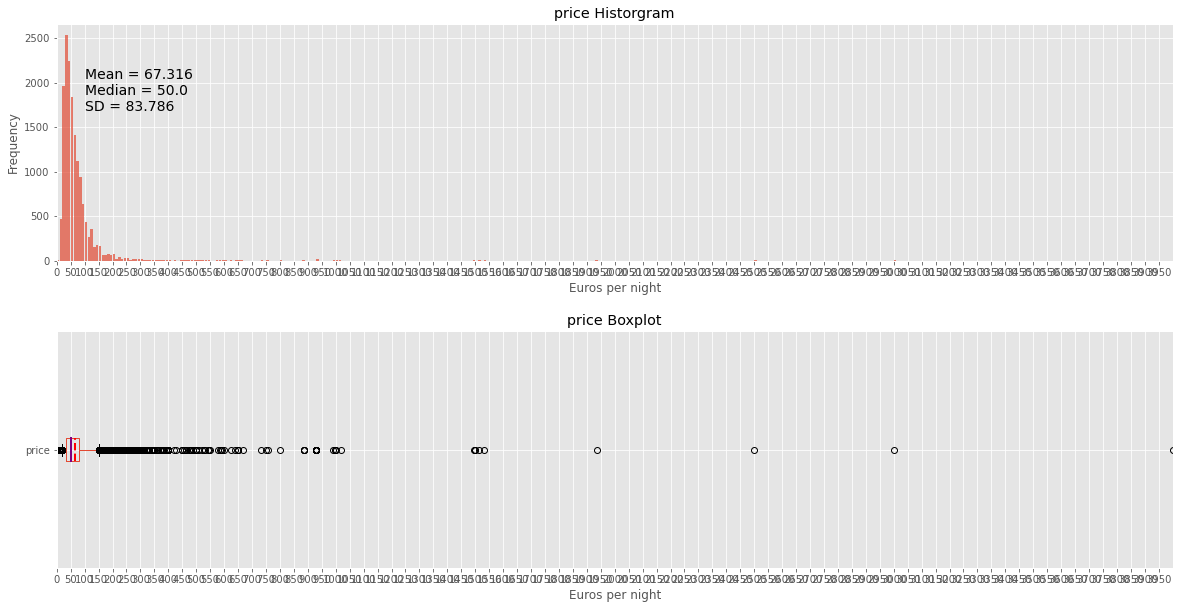

In [8]:
column = 'price' #variable to plot
text_xy = (100, 1500) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=0, xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=0, d_max=d_tuple[1], d_binw=10)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1), #skinnier like book
                     title=f'{column} Boxplot')

In [9]:
df_berlin['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    4000.0
0.95     150.0
0.75      79.0
0.50      50.0
0.25      35.0
0.05      20.0
0.00       8.0
Name: price, dtype: float64

**Observations**
- the price mean is larger than median (positive-skew) due to high-priced "luxury" outliers
- these are very high outliers, so remove them in the next section

### Price after removing outliers

For better analysis (a more representative mean) and better graphing, we remove prices from 500 EUR and above.<br>
Then replot histogram and boxplot.

In [10]:
#berlin_airbnb = berlin_airbnb[berlin_airbnb.price < 1000] # To get around the long tail outliers
df_berlin = df_berlin[df_berlin['price'] < 500]
df_berlin['terrace'].value_counts()
df_berlin['terrace'].value_counts(normalize=True)

False    14599
True       696
Name: terrace, dtype: int64

False    0.954495
True     0.045505
Name: terrace, dtype: float64

Text(100, 1500, 'Mean = 63.421\nMedian = 50.0\nSD = 46.151\n')

<AxesSubplot:title={'center':'price Historgram'}, xlabel='Euros per night', ylabel='Frequency'>

<AxesSubplot:xlabel='Euros per night'>

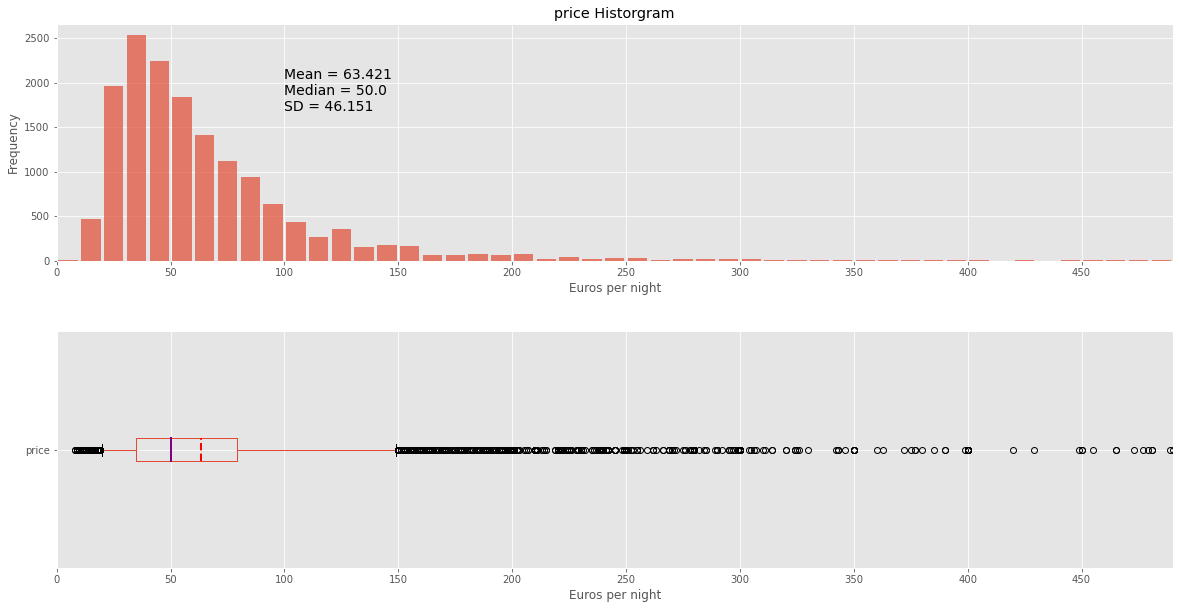

In [11]:
column = 'price' #variable to plot
text_xy = (100, 1500) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=0, xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=0, d_max=d_tuple[1], d_binw=10)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1)) #skinnier like book

In [12]:
df_berlin['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    490.0
0.95    149.0
0.75     79.0
0.50     50.0
0.25     35.0
0.05     20.0
0.00      8.0
Name: price, dtype: float64

**Observations**<br>
As expected, after removing outliers from 500 EUR and above:
- the price mean moves closer to the median from 67 to 63 EUR
- the price median doesn't change at 50 EUR
- the Standard Deviation (SD) almost halved from 84 to 46 EUR

### Price by-terrace
Let's see how the price distributions differ by whether it has a terrace or not.<br>
Run same plots grouped by "terrace".<br>

**Note:**
- For histograms, we need to **normalize** because of the unbalanced classes, and for comparison to the Kernel Density Estimate (KDE)

**Python:**
- first use fo Pandas `groupby` in this project, how lovely and useful it is!

In [13]:
df_berlin.groupby('terrace')['price'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
terrace,,,,,,,,
False,14599.0,61.852,44.338,8.0,35.0,50.0,75.0,490.0
True,696.0,96.338,66.641,9.0,50.0,80.0,120.0,479.0


**Observations:**<br>
Just from `describe`, we can already see a shift to pricier places when a "terrace" is present:
- the mean shifts up from 62 to 96 EUR
- **the median (50%) also shifts up from 50 to 80 EUR** so the mean shift is not just due to a few expensive outliers
- there is a 9 EUR per night rental wth a terrace available!

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: price, dtype: object

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: price, dtype: object

<AxesSubplot:title={'center':'price'}, xlabel='terrace'>

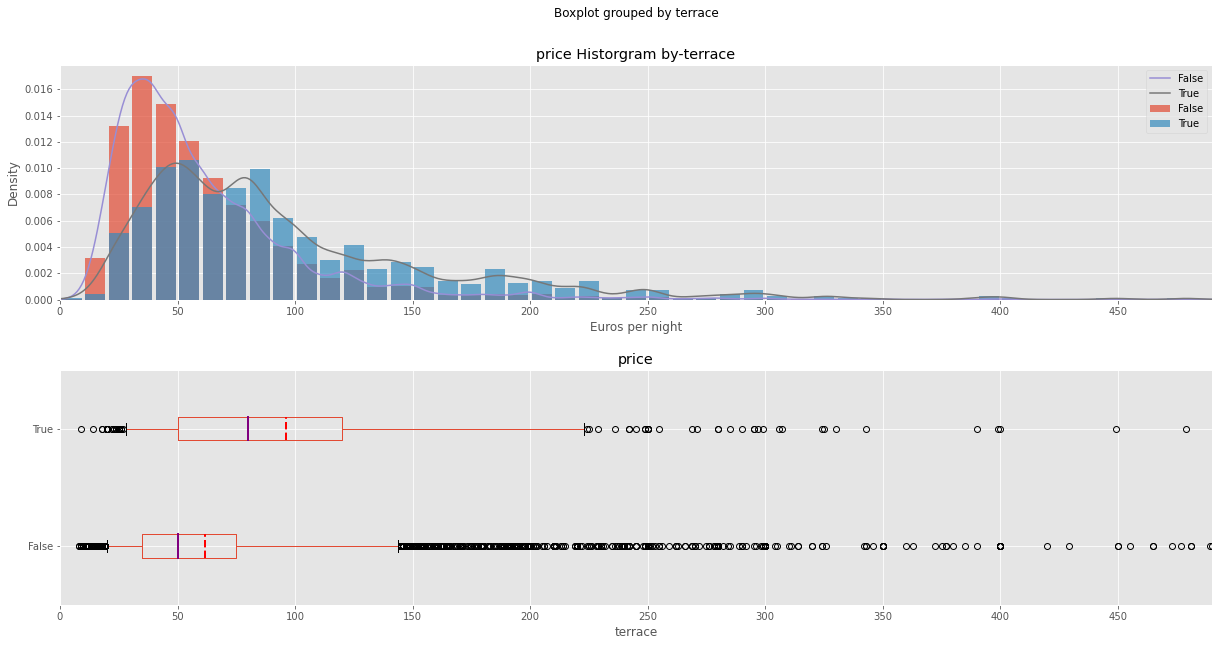

In [14]:
column = 'price' #variable to plot
group = 'terrace' #variable to group-"by"

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
#d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
d_tuple = (0, df_berlin[column].max().max()) # hardcode min to 0
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=50, xlabel='Euros per night')

#Histogram binning setup based on (d)ata, bin width = data granularity of 10 Euros
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=10)

df_berlin.groupby(group)[column].plot.hist(ax=axes[0], density=True,
                                                   bins=d_bins,
                                                   rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                                                   title=f'{column} Historgram by-terrace',
                                                   legend=True)
df_berlin.groupby(group)[column].plot.kde(ax=axes[0],
                                                  bw_method=0.1, legend=True) #bw_method='scott' (default), 'silverman', scalar
    
df_berlin.boxplot(by=group, column=column, ax=axes[1], vert=False,
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.2)) #skinnier like book

In [15]:
df_berlin.groupby('terrace')['price'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

terrace      
False    1.00    490.00
         0.95    144.00
         0.75     75.00
         0.50     50.00
         0.25     35.00
         0.05     20.00
         0.00      8.00
True     1.00    479.00
         0.95    223.25
         0.75    120.00
         0.50     80.00
         0.25     50.00
         0.05     27.75
         0.00      9.00
Name: price, dtype: float64

**Observations:**
- the historgrams and KDEs grouped by terrace True vs. False indeed shift to higher prices and more spread out (higher SD) prices
- terrace True looks bi-modal at around 50 and 80 EUR
- differences are prominent in box plots as well

### Review score rating - initial checks
Similar analysis for rating as we did for price:
- keep all values because of bounded range from 20-100

Text(85, 2000, 'Mean = 94.53\nMedian = 97.0\nSD = 8.279\n')

<AxesSubplot:title={'center':'rating Historgram'}, xlabel='Review score rating out of 100', ylabel='Frequency'>

<AxesSubplot:title={'center':'rating Boxplot'}, xlabel='Review score rating out of 100'>

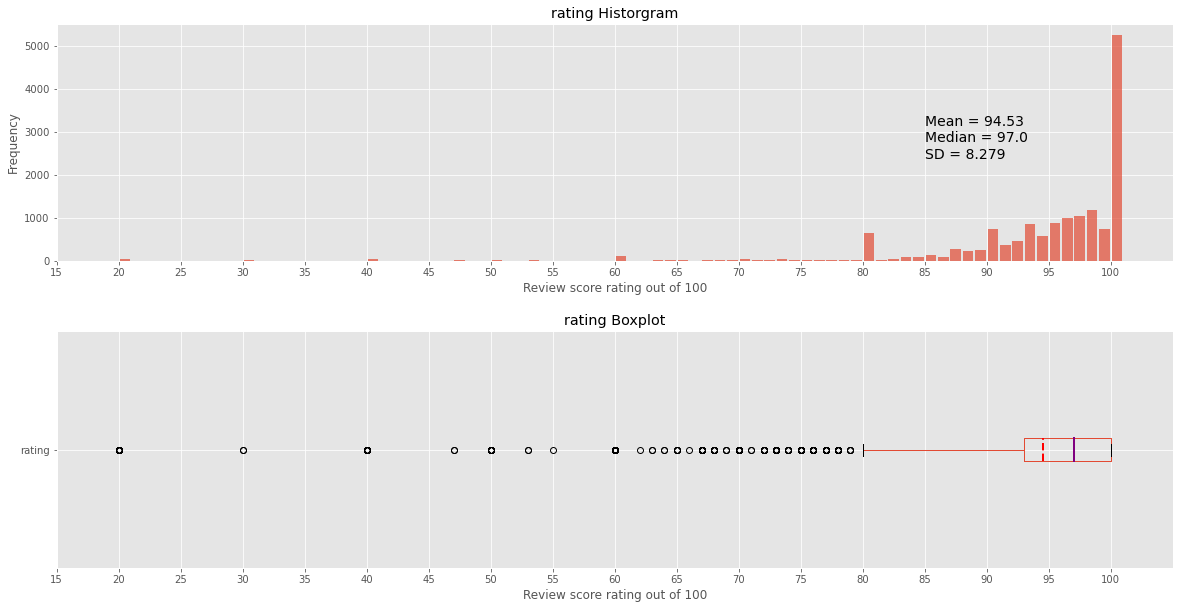

In [16]:
column = 'rating' #variable to plot
text_xy = (85, 2000) #Matplotlib text() uses data coordinates, need to adjust for each attribute's histogram

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (df_berlin[column].min().min(), df_berlin[column].max().max())
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=5, x_padding=5, xlabel='Review score rating out of 100')

#Histogram binning setup based on (d)ata, bin width = data granularity of 1 (many scores bunched up in 90s)
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=1)

axes[0].text(text_xy[0], text_xy[1],
             f'Mean = {df_berlin[column].mean().round(3)}\n'
             f'Median = {df_berlin[column].median().round(3)}\n'
             f'SD = {df_berlin[column].std().round(3)}\n', fontsize=14)

df_berlin[column].plot.hist(ax=axes[0], bins=d_bins,
                            rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                            title=f'{column} Historgram')

df_berlin[column].plot.box(ax=axes[1], vert=False, #horizontal!
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.1), #skinnier like book
                     title=f'{column} Boxplot')

In [17]:
df_berlin['rating'].quantile([1, 0.95, 0.75, 0.5, 0.25, 0.05, 0])

1.00    100.0
0.95    100.0
0.75    100.0
0.50     97.0
0.25     93.0
0.05     80.0
0.00     20.0
Name: rating, dtype: float64

**Observations:**
- Rating is ery negative-skewed with the mean less than the median due to "bad rating" outliers (less than 80)
- IQR box (25-75/100%) is bunched up in the high ratings: 90s to the maximum of 100 (93-100)
- a ratings mode of 100! (something to explore later?)

### Review score ratings - by-terrace
Similar analysis for rating by-terrace as we did for price.

In [18]:
df_berlin.groupby('terrace')['rating'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
terrace,,,,,,,,
False,14599.0,94.456,8.386,20.0,92.0,97.0,100.0,100.0
True,696.0,96.085,5.367,60.0,95.0,98.0,100.0,100.0


**Observations:**<br>
From `describe`, we can see:
- the rating mean and median do shift up slightly for terrace True
- interestingly, the ratings spread is tighter (smaller SD) for terraces, as opposed to the wider price spread
    - but low rating outliers also affect SD so take with a grain of salt
    - infer: "while terrace prices have a wider range, the satisfication with them are more consistenly high"

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: rating, dtype: object

terrace
False    AxesSubplot(0.125,0.551739;0.775x0.328261)
True     AxesSubplot(0.125,0.551739;0.775x0.328261)
Name: rating, dtype: object

<AxesSubplot:title={'center':'rating'}, xlabel='terrace'>

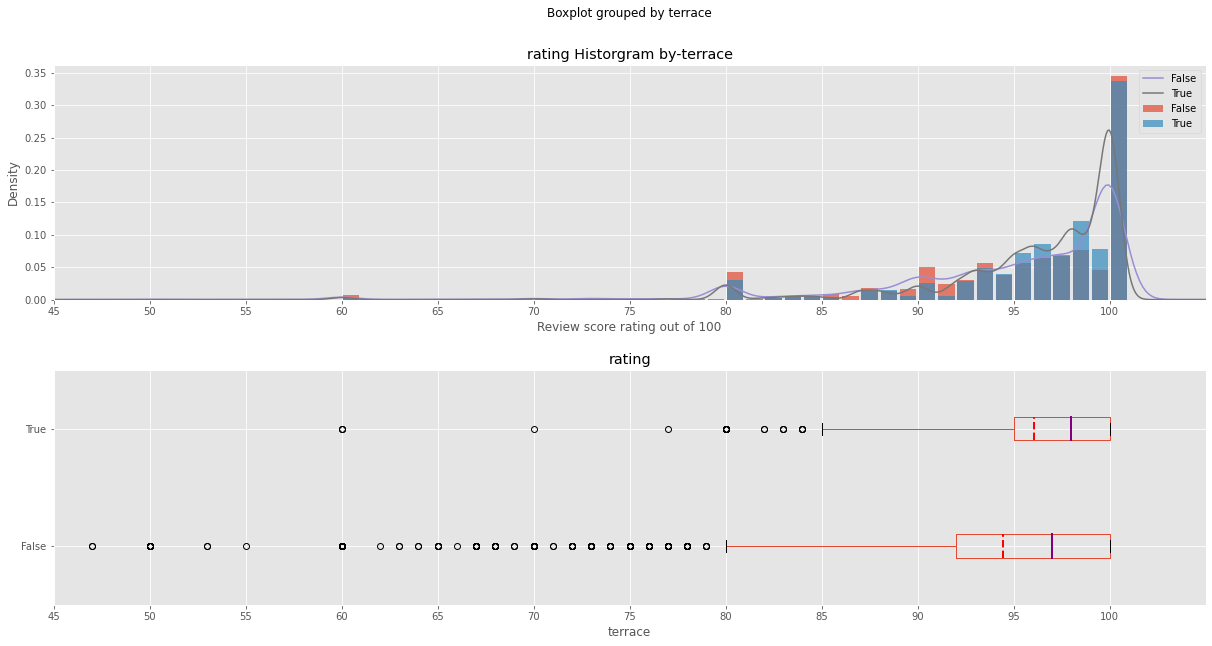

In [19]:
column = 'rating' #variable to plot
group = 'terrace' #variable to group-"by"

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

#setup plot grids based on (d)ata
d_tuple = (50, df_berlin[column].max().max()) # hardcode min to 50
plot_setup(xd_min=d_tuple[0], xd_max=d_tuple[1], x_grid=5, x_padding=5, xlabel='Review score rating out of 100')

#Histogram binning setup based on (d)ata, bin width = data granularity of 1 rating score
d_bins = histogram_bins(d_min=d_tuple[0], d_max=d_tuple[1], d_binw=1)

df_berlin.groupby(group)[column].plot.hist(ax=axes[0], density=True,
                                                   bins=d_bins,
                                                   rwidth=0.85, alpha=0.7, #from RealPython.com: alpha for transparency
                                                   title=f'{column} Historgram by-terrace',
                                                   legend=True)
df_berlin.groupby(group)[column].plot.kde(ax=axes[0],
                                                  bw_method=0.1, legend=True) #bw_method='scott' (default), 'silverman', scalar
    
df_berlin.boxplot(by=group, column=column, ax=axes[1], vert=False,
                     medianprops={'linewidth': 2, 'color': 'purple'},
                     showmeans=True, meanline=True, meanprops={'linewidth': 2, 'color': 'red'},
                     whis=(5,95), #default whis=1.5*IQR
                     widths=(0.2)) #skinnier like book

**Observations:**<br>
- difficult to see much difference in histogram/KDE plots
- box plots are better here for showing the slightly higher ratings for terraces

### Multivariate - numeric
Compare price and rating using a **scatter plot** to answer the question: is there any relationship between price and rating?

[Text(0.5, 0, 'price'), Text(0, 0.5, 'rating')]

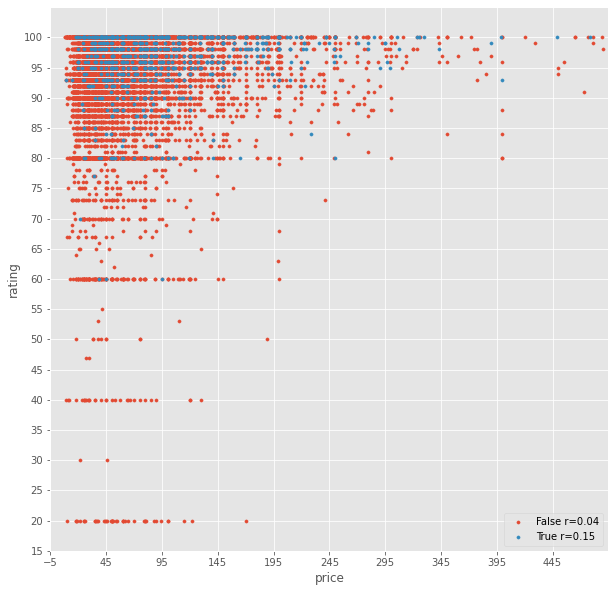

In [20]:
xcol = 'price'
ycol = 'rating'
group = 'terrace'

#create subplots: setup 1x1 Axes in one Figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

#setup plot grids based on (d)ata #hard code min/max to zoom
plot_setup(xd_min=0, xd_max=df_berlin[xcol].max(), x_grid=50, x_padding=5,
           ysetup=True, yd_min=df_berlin[ycol].min(), yd_max=df_berlin[ycol].max(), y_grid=5, y_padding=5)

#df_berlin.plot.scatter(ax=ax, x=xcol, y=ycol, c=df_berlin['terrace'], colormap='summer')

corr_vars = dict(pearson='r', spearman='rho', kendall='tau')
corr_method = 'pearson' #'pearson', 'spearman', 'kendall'

# use Matplotlib native "scatter" for fuller control
#Scatter plot by-class (groupby)
df_berlin_grouped = df_berlin.groupby(group) #for each group: tuple of (name, subsetted object)
for group_name, group in df_berlin_grouped:
    label = f'{group_name} {corr_vars[corr_method]}={group.corr(method=corr_method).at[xcol,ycol].round(2)}'
    axes.scatter(x=group[xcol], y=group[ycol], label=label, s=10)
            
axes.set(xlabel=xcol, ylabel=ycol)
axes.legend()

**Observations**
- discrete ratings lines at 20, 40, 60, 80
- terrace True has a tighter "bunch-up" at high (90+) ratings
- not indicated in correlation measures, but visually, there is a logarithmic-looking "curved boundary" that suggests:
    - higher prices have more exclusively high ratings (more effort by hosts?)
    - lower prices also have high ratings but includes more low ratings (more mixed quality)

### Experiment: price vs. ratings "range"
Let's plot this and see what we get.

<AxesSubplot:xlabel='price'>

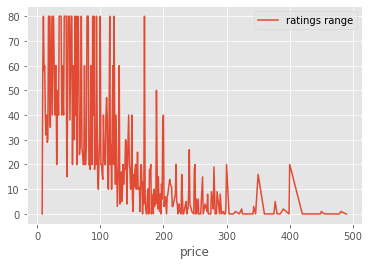

In [21]:
pd.DataFrame(df_berlin.groupby('price').apply(lambda x: x['rating'].max() - x['rating'].min()),
             columns=['ratings range']).plot()

**Observations:**
- Yes! Noisy (would be good to bin prices) but we do see a trend of higher prices correlating to smaller ratings **ranges**

### Univariate - categorical
A quick look at our categorical variables.

In [22]:
df_berlin.describe(include='category')

,neighbourhood,district,property_type,room_type
count,15295,15295,15295,15295
unique,136,12,63,4
top,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,Entire apartment,Entire home/apt
freq,874,3514,7404,8499


### Districts - listings vs. terraces per-district
Which districts have high/low % of terraces within their listings normalized to the entire (current) dataset?

,listings_norm,terrace_norm
Charlottenburg-Wilmersdorf,0.079830,0.071839
Friedrichshain-Kreuzberg,0.229748,0.225575
Lichtenberg,0.028571,0.033046
Marzahn-Hellersdorf,0.006080,0.004310
Mitte,0.213992,0.225575
Neukölln,0.141092,0.089080
Pankow,0.163387,0.206897
Reinickendorf,0.013403,0.015805
Spandau,0.007192,0.011494
Steglitz-Zehlendorf,0.019287,0.027299


<AxesSubplot:title={'center':'Listings vs. Terraces (normalized to 1) per-District'}>

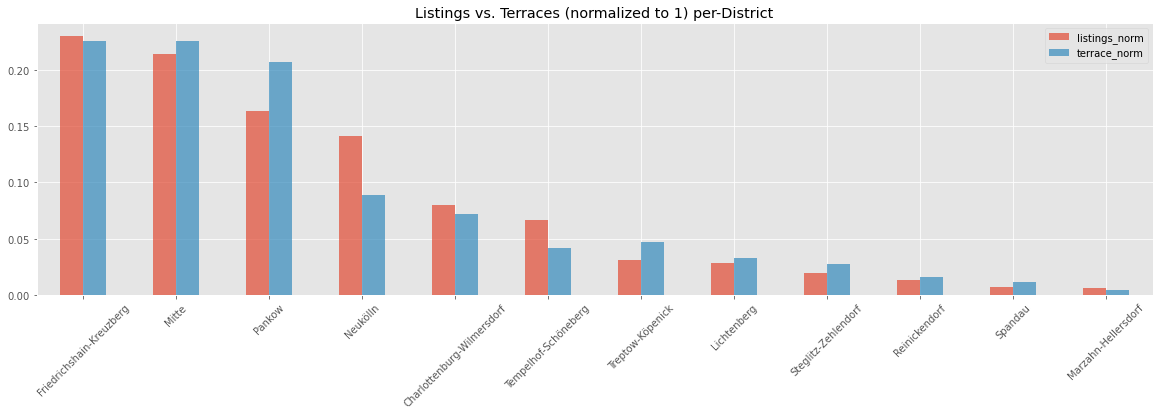

In [23]:
xcol = 'district'
group = 'terrace'

# setup DataFrame for normalized per-district data
df_berlin_district_norm = pd.DataFrame(
    {'listings_norm': df_berlin[xcol].value_counts()/df_berlin[xcol].count(),
     'terrace_norm' : df_berlin.loc[df_berlin[group], xcol].value_counts()/df_berlin[group].sum()})
df_berlin_district_norm

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
df_berlin_district_norm.sort_values(by='listings_norm', ascending=False).plot.bar(ax=axes, rot=45, alpha=0.7,
                                 title='Listings vs. Terraces (normalized to 1) per-District')

**Observations:**
- Fairly similar normalized listings vs terrace % per-district
- Setting absolute number of listings aside:
    - Pankow is the best bet to find a terrace compared to its share of listings
    - Neukölln is the least likely district to find a terrace compared to its share of listings

### Room type
Which types of rental formats have high/low % of terraces within their listings normalized to the entire (current) dataset?

,listings_norm,terrace_norm
Entire home/apt,0.555672,0.731322
Hotel room,0.007192,0.008621
Private room,0.423537,0.257184
Shared room,0.013599,0.002874


<AxesSubplot:title={'center':'Listings vs. Terraces (normalized to 1) per-Room Type'}>

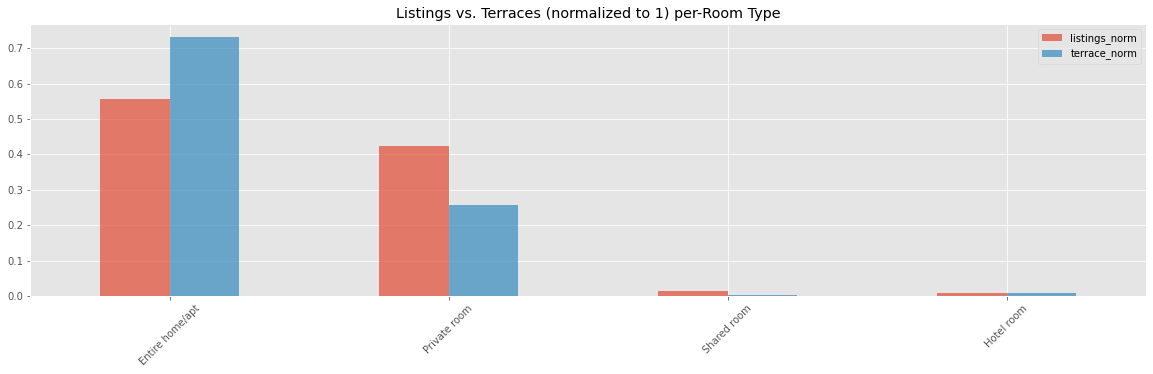

In [24]:
xcol = 'room_type'
group = 'terrace'

# setup DataFrame for normalized per-district data
df_berlin_room_type_norm = pd.DataFrame(
    {'listings_norm': df_berlin[xcol].value_counts()/df_berlin[xcol].count(),
     'terrace_norm' : df_berlin.loc[df_berlin[group], xcol].value_counts()/df_berlin[group].sum()})
df_berlin_room_type_norm

#create subplots: setup 2x2 Axes in one Figure 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
df_berlin_room_type_norm.sort_values(by='listings_norm', ascending=False).plot.bar(ax=axes, rot=45, alpha=0.7,
                                 title='Listings vs. Terraces (normalized to 1) per-Room Type')

**Observations:**
- Stronger data than district is room type!
    - better choices in "Entire home/apt" than for "Private room" which makes functional sense
    - shared and hotel rooms have very small numbers but "Shared room" is looking like the worse bet for finding a terrace

### Multivariate - categorical

This basically a Pivot Table (Microsoft Excel) style of comparison between our categorical variables.

**Python - Pandas**
- discovered `crosstab` which seems to be `pivot_table` with the ability to normalize (get a %) by rows or columns

In [25]:
# use crosstab to normalize (i.e. % by row) for each district
pd.crosstab(df_berlin.loc[df_berlin[group]]['district'], df_berlin.loc[df_berlin[group]]['room_type'])
pd.crosstab(df_berlin.loc[df_berlin[group]]['district'], df_berlin.loc[df_berlin[group]]['room_type'],
            normalize='index')

room_type,Entire home/apt,Hotel room,Private room,Shared room
district,,,,
Charlottenburg-Wilmersdorf,36,0,14,0
Friedrichshain-Kreuzberg,111,0,45,1
Lichtenberg,17,0,6,0
Marzahn-Hellersdorf,2,0,1,0
Mitte,115,6,36,0
Neukölln,37,0,24,1
Pankow,118,0,26,0
Reinickendorf,7,0,4,0
Spandau,6,0,2,0


room_type,Entire home/apt,Hotel room,Private room,Shared room
district,,,,
Charlottenburg-Wilmersdorf,0.720000,0.000000,0.280000,0.000000
Friedrichshain-Kreuzberg,0.707006,0.000000,0.286624,0.006369
Lichtenberg,0.739130,0.000000,0.260870,0.000000
Marzahn-Hellersdorf,0.666667,0.000000,0.333333,0.000000
Mitte,0.732484,0.038217,0.229299,0.000000
Neukölln,0.596774,0.000000,0.387097,0.016129
Pankow,0.819444,0.000000,0.180556,0.000000
Reinickendorf,0.636364,0.000000,0.363636,0.000000
Spandau,0.750000,0.000000,0.250000,0.000000


**Observations:**
- more Entire home/apt's with terraces than other room types holds up by-district
- Pankow sticks out again for having the largest % of its terraces in "Entire home/apt" at 82%

### Data exploration - observations summary
Best potential features for predicting terraces:
- higher prices
- more consistent high ratings
- district: Pankow >> Neukölln
- room type: Entire room/apt >> Private room >> Shared room

Feature relationships:
- Price vs ratings **range** (negative correlation)

## 3. Pre-process data

**Scikit-learn's** decision trees do not allow categorical data as inputs so need to encode our categorical variables first to binary using `OneHotEncoder` which makes intuitive sense since Scikit-learn's `DecisionTreeClassifier` uses the CART algorithm which creates binary-split decision trees.

**Note:"
- split the data before encoding to follow the "don't introduce data leakage" rule.

### Split data
Split into training (67%) and test (33%) data.

In [26]:
# separate X (features) and y (class) columns
X_cols = ['district', 'room_type', 'price', 'rating']
df_berlin_X = df_berlin[X_cols]
df_berlin_y = df_berlin['terrace']

# split the dataset into train and test sets (returns DataFrame for X!)
df_X_train, df_X_test, s_y_train, s_y_test = train_test_split(df_berlin_X, df_berlin_y, test_size=0.33, random_state=1)

### Encode categorical data

Besides encoding, we also need to separate the categorical (for encoding) fom the numerical (leave as-is) columns, and then re-combine. I keep all data in **Pandas** DataFrames here for visibility's sake.

**Python:**
- need Pandas `reset_value` to re-align DataFrame indexes

In [27]:
# separate X numerical, categorical columns
X_num = df_X_train.select_dtypes('number').columns
X_cat = df_X_train.select_dtypes('category').columns
y_label = s_y_train.name

# reset indexing so re-combining num and cat columns works
df_X_train.reset_index(inplace=True, drop=True)
s_y_train.reset_index(inplace=True, drop=True)
df_X_test.reset_index(inplace=True, drop=True)
s_y_test.reset_index(inplace=True, drop=True)

# one-hot encode categorical attributes only
onehotenc = OneHotEncoder(sparse=False)
df_X_train_catenc = pd.DataFrame(
    onehotenc.fit_transform(df_X_train[X_cat]),
    columns=onehotenc.get_feature_names(X_cat))
df_X_test_catenc = pd.DataFrame(
    onehotenc.transform(df_X_test[X_cat]),
    columns=onehotenc.get_feature_names(X_cat))

#combine back with numerical attributes
df_X_train_enc = pd.concat([df_X_train_catenc, df_X_train[X_num]], axis=1)
df_X_test_enc = pd.concat([df_X_test_catenc, df_X_test[X_num]], axis=1)

#also need to encode the Y "label" (class) data
labelenc = LabelEncoder()
s_y_train_enc = pd.Series(labelenc.fit_transform(s_y_train), name=y_label)
s_y_test_enc = pd.Series(labelenc.transform(s_y_test), name=y_label)

## 4. Build model
Instantiate and fit `DecisionTreeClassifier`.<br>
Then check [feature importance](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3) and the better (normalized) [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html) results to see which features do the most decision "work" in the resulting tree. 

**Notes:**
- using a tree depth of 10 here for a reasonable number of 241 leaf nodes
- plotting deep trees is a bit problematic with the many leaf nodes bunched up in the resulting plot

**Python:**
- need NumPy `astype(str)` to input **boolean** class values as printable strings

In [28]:
dt_model = DecisionTreeClassifier(criterion='gini', random_state=1, max_depth=10)
dt_model = dt_model.fit(df_X_train_enc, s_y_train_enc)

print ("Resulting tree has a depth of: ", dt_model.get_depth())
print ("Resulting tree has this number of leaf nodes: ", dt_model.get_n_leaves())

# Feature Importances calculation
df_model_fi = pd.DataFrame(index=df_X_train_enc.columns)
df_model_fi['feature_importances_'] = dt_model.feature_importances_

# Better Permutation Feature Importances
df_model_fi['permutation_importances_train'] = permutation_importance(
    dt_model, df_X_train_enc, s_y_train_enc, n_repeats=30, random_state=1)['importances_mean']
df_model_fi['permutation_importances_train_norm'] = df_model_fi[
    'permutation_importances_train']/df_model_fi['permutation_importances_train'].sum()
df_model_fi.sort_values(by='feature_importances_', ascending=False)

# plot built tree
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(100,100))
#plot_tree(dt_model, ax=ax, fontsize=12, filled=True, rounded=True,
#          feature_names=df_X_train_enc.columns, class_names=labelenc.classes_.astype(str))
#plt.savefig('images/berlin_terraces_tree_balanced_depth11.png')


Resulting tree has a depth of:  10
Resulting tree has this number of leaf nodes:  241


,feature_importances_,permutation_importances_train,permutation_importances_train_norm
price,0.483909,0.015517,0.389229
rating,0.310029,0.009622,0.241371
district_Mitte,0.036072,0.000963,0.024153
room_type_Entire home/apt,0.020644,0.000797,0.019992
district_Friedrichshain-Kreuzberg,0.019095,0.000381,0.009547
room_type_Hotel room,0.014747,0.001828,0.045859
room_type_Private room,0.013847,0.001958,0.049123
district_Reinickendorf,0.013499,0.000667,0.016728
district_Pankow,0.013480,0.000729,0.018278
district_Spandau,0.012327,0.001422,0.035659


**Observations:**
- Indeed, price and rating are the most important features for our current data

## 5. Evaluate model
Let's see how the model does against our test data using the very helfpul **Confusion Matrix**, particularly the **True recall** score meaning how many of the actual terraces are being predicted as terraces by our decision tree model?

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      4813
        True       0.06      0.01      0.01       235

    accuracy                           0.95      5048
   macro avg       0.51      0.50      0.49      5048
weighted avg       0.91      0.95      0.93      5048



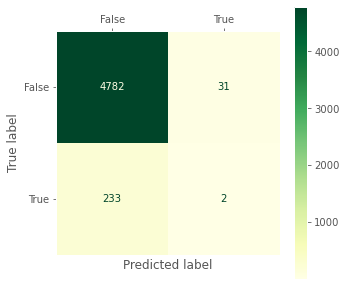

In [29]:
s_y_predicted = pd.Series(dt_model.predict(df_X_test_enc), name=y_label)
#accuracy_score(s_Y_test, s_Y_predicted)
#golf_tree.score(df_X_test, s_Y_test) #returns "score: Mean accuracy of self.predict(X) wrt. y."

#confusion_matrix(s_Y_test, s_Y_predicted) #normalize: {‘true’, ‘pred’, ‘all’}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.grid(False)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plot_confusion_matrix(dt_model, df_X_test_enc, s_y_test_enc,
                      display_labels=labelenc.classes_.astype(str), cmap='YlGn', ax=ax)

print(classification_report(s_y_test_enc, s_y_predicted, target_names=labelenc.classes_.astype(str)))

**Observations:**
- Not good! only 2 out of the 235 terraces (or 1%) in the test data were predicted to be terraces!
- Remove the max_depth constraint (resulting depth of 26) gave the best true recall at a still low 6%

### Balance Class Weights!
I had a feeling that the [unbalanced](https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/) class weights are the problem. Thankfully, the `DecisionTreeClassifier` has a **class_weight** parameter to do exactly that!<br>
Let's re-build the model with **balanced classes**.

Resulting tree has a depth of:  11
Resulting tree has this number of leaf nodes:  268


,feature_importances_,permutation_importances_train,permutation_importances_train_norm
price,5.776822e-01,-0.012901,1.669895
rating,2.116373e-01,0.016096,-2.083368
district_Friedrichshain-Kreuzberg,3.004305e-02,0.001688,-0.218526
district_Treptow-Köpenick,2.530617e-02,0.003126,-0.404632
room_type_Entire home/apt,2.476623e-02,-0.017260,2.234105
district_Tempelhof-Schöneberg,2.064906e-02,0.005228,-0.676632
district_Mitte,2.023490e-02,0.001002,-0.129684
district_Neukölln,1.604763e-02,0.001330,-0.172211
district_Pankow,1.414945e-02,0.004775,-0.618105
room_type_Private room,1.054852e-02,-0.016480,2.133053


              precision    recall  f1-score   support

       False       0.97      0.62      0.76      4813
        True       0.07      0.56      0.12       235

    accuracy                           0.62      5048
   macro avg       0.52      0.59      0.44      5048
weighted avg       0.93      0.62      0.73      5048



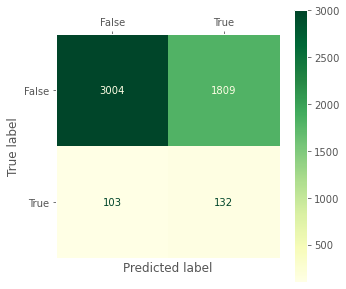

In [30]:
# BUILD MODEL
dt_model = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced', max_depth=11)
dt_model = dt_model.fit(df_X_train_enc, s_y_train_enc)

print ("Resulting tree has a depth of: ", dt_model.get_depth())
print ("Resulting tree has this number of leaf nodes: ", dt_model.get_n_leaves())

# Feature Importances calculation
df_model_fi = pd.DataFrame(index=df_X_train_enc.columns)
df_model_fi['feature_importances_'] = dt_model.feature_importances_

# Better Permutation Feature Importances
df_model_fi['permutation_importances_train'] = permutation_importance(
    dt_model, df_X_train_enc, s_y_train_enc, n_repeats=30, random_state=1)['importances_mean']
df_model_fi['permutation_importances_train_norm'] = df_model_fi[
    'permutation_importances_train']/df_model_fi['permutation_importances_train'].sum()
df_model_fi.sort_values(by='feature_importances_', ascending=False)

# EVALUATE MODEL
s_y_predicted = pd.Series(dt_model.predict(df_X_test_enc), name=y_label)
#accuracy_score(s_Y_test, s_Y_predicted)
#golf_tree.score(df_X_test, s_Y_test) #returns "score: Mean accuracy of self.predict(X) wrt. y."

#confusion_matrix(s_Y_test, s_Y_predicted) #normalize: {‘true’, ‘pred’, ‘all’}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.grid(False)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plot_confusion_matrix(dt_model, df_X_test_enc, s_y_test_enc,
                      display_labels=labelenc.classes_.astype(str), cmap='YlGn', ax=ax)

print(classification_report(s_y_test_enc, s_y_predicted, target_names=labelenc.classes_.astype(str)))

**Observations:**<br>
And here are my "Aha!" moments:
- balanced weight classes (with no max_depth constraint) boosted terrace=True recall from 1% to 12% (some hope)
- pruning down and then back up using **max_depth**, I hit a peak **True recall of 56% (!!)** at tree depth of 11
- this definitely needs a GridSearchCV to see how much higher we can get this up
- not sure what happened to the permutation importances going negative, need to explore...

## 6. Optimize model
### Grid search (tuning paramaters) and cross-validate (training/test data variation)
Use the amazing [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) which does grid search (vary a prescribed "grid" of parameters x value ranges) AND [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) of data in **one line of code**.

In [31]:
# define the model (its parameters will be grid-searched)
opt_model = DecisionTreeClassifier(random_state=1, class_weight='balanced')

# define search space
param_grid = dict()
param_grid['criterion'] = ['gini', 'entropy']
param_grid['max_depth'] = np.arange(5, 15) #arange does not include last element, rounding error N/A for integers
param_grid['min_samples_split'] = np.arange(2, 6) #logically >= min_samples_leaf + 1
param_grid['min_samples_leaf'] = np.arange(1, 5)
param_grid['min_impurity_decrease'] = [0, 0.25, 0.5] #gini vs entropy

# combine training and test (n=28) one-hot-encoded X, Y data from above
df_X_all_enc = pd.concat([df_X_train_enc, df_X_test_enc]) #indexes are still [0..n, 0..n] but that's OK
s_y_all_enc = pd.concat([s_y_train_enc, s_y_test_enc]) #indexes are still [0..n, 0..n] but that's OK

# define search
search = GridSearchCV(opt_model, param_grid,
                      scoring='accuracy', #uses metrics.accuracy_score
                      cv=4, #current dataset n=~15k so 5 K-folds of n=~3k each
                      refit=True) #Refit an estimator using the best found parameters on the whole dataset.

# execute search
result = search.fit(df_X_all_enc, s_y_all_enc)

# output results
print("Best cross-validated recall score:", result.best_score_) #Mean cross-validated score of the best_estimator
result.best_params_ #Parameter setting that gave the best results on the hold out data

df_cv_results = pd.DataFrame(result.cv_results_) #A dict with keys as column headers and values as columns
df_cv_results.loc[df_cv_results['rank_test_score'] == 1]
print("Min split score:", df_cv_results[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']].min().min())
print("Max split score:",df_cv_results[['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']].max().max())
#df_cv_results.to_csv('./results/golf_decision_tree_gridsearchcv_results.csv', index=False) #write CSV



Best cross-validated recall score: 0.7131738728758001


{'criterion': 'gini',
 'max_depth': 14,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
432,0.065373,0.013773,0.009212,0.003447,gini,14,0,1,2,"{'criterion': 'gini', 'max_depth': 14, 'min_im...",0.725418,0.726987,0.69273,0.70756,0.713174,0.014055,1


Min split score: 0.045502092050209206
Max split score: 0.7881245095474758


**Observations:**
- These numbers looks promising for an improved recall score. Let's see how the "best" estimator does now against the original test data.

### Optimized Model Evaluation
We use the best model output from `GridSearchCV` and plug that back into our evaluation methods from above.

              precision    recall  f1-score   support

       False       0.99      0.72      0.84      4813
        True       0.14      0.91      0.24       235

    accuracy                           0.73      5048
   macro avg       0.57      0.81      0.54      5048
weighted avg       0.95      0.73      0.81      5048



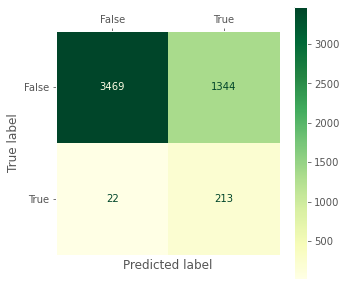

In [32]:
# get the best performing model fit on the whole training set
best_model = result.best_estimator_

# EVALUATE MODEL
s_y_predicted = pd.Series(best_model.predict(df_X_test_enc), name=y_label)
#accuracy_score(s_Y_test, s_Y_predicted)
#golf_tree.score(df_X_test, s_Y_test) #returns "score: Mean accuracy of self.predict(X) wrt. y."

#confusion_matrix(s_Y_test, s_Y_predicted) #normalize: {‘true’, ‘pred’, ‘all’}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.grid(False)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plot_confusion_matrix(best_model, df_X_test_enc, s_y_test_enc,
                      display_labels=labelenc.classes_.astype(str), cmap='YlGn', ax=ax)

print(classification_report(s_y_test_enc, s_y_predicted, target_names=labelenc.classes_.astype(str)))

**Observations:**
- A terrace **True recall of 91% (!!)** looks almost too good to be true. A deep dive into the this "best model" tree is required to really understand how this is happening... But still a worth a look at feature and permutation importances as before.

In [33]:
# Feature Importances calculation
df_best_model_fi = pd.DataFrame(index=df_X_train_enc.columns)
df_best_model_fi['feature_importances_'] = best_model.feature_importances_

# Better Permutation Feature Importances
df_best_model_fi['permutation_importances_train'] = permutation_importance(
    best_model, df_X_train_enc, s_y_train_enc, n_repeats=30, random_state=1)['importances_mean']
df_best_model_fi['permutation_importances_train_norm'] = df_best_model_fi[
    'permutation_importances_train']/df_best_model_fi['permutation_importances_train'].sum()
df_best_model_fi.sort_values(by='permutation_importances_train_norm', ascending=False)

,feature_importances_,permutation_importances_train,permutation_importances_train_norm
rating,0.205126,0.030627,0.331479
price,0.551903,0.020022,0.216702
district_Friedrichshain-Kreuzberg,0.022578,0.010299,0.111467
district_Pankow,0.028918,0.009870,0.106820
district_Charlottenburg-Wilmersdorf,0.014189,0.007527,0.081470
district_Tempelhof-Schöneberg,0.021859,0.006695,0.072457
district_Neukölln,0.020776,0.006428,0.069570
district_Mitte,0.024709,0.006252,0.067669
district_Treptow-Köpenick,0.017265,0.002472,0.026758
district_Lichtenberg,0.011561,0.002193,0.023730


**Observations:**
- Looking only at **permutation importance**, this metric using this optimized decision tree model tells us that the top 5 ways to find a terrace in Berlin are by looking at:
    1. Rating
    2. Price
    3. Is the listing in Friedrichshain-Kreuzberg?
    4. Is the listing in Pankow?
    5. Is the listing in Charlottenburg-Wilmersdorf?